# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [ ]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import timeseries_dataset_from_array

In [219]:
df = pd.read_csv('/content/Traffic Data.csv', parse_dates=['date_time'])
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [6]:
df.tail()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00
19999,5042.0,301.65,0.0,0.0,40,Clouds,scattered clouds,2018-05-31 18:00:00


In [220]:
df.set_index('date_time', inplace=True)

In [16]:
df['weather_description'].unique()

array(['mist', 'sky is clear', 'broken clouds', 'moderate rain',
       'proximity shower rain', 'proximity thunderstorm', 'fog',
       'light rain', 'overcast clouds', 'light intensity drizzle',
       'scattered clouds', 'proximity thunderstorm with rain',
       'light snow', 'haze', 'few clouds', 'heavy intensity rain', 'snow',
       'drizzle', 'heavy intensity drizzle', 'thunderstorm',
       'Sky is Clear', 'heavy snow', 'thunderstorm with heavy rain',
       'light shower snow', 'shower drizzle',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'thunderstorm with light drizzle',
       'proximity thunderstorm with drizzle', 'smoke',
       'light intensity shower rain', 'sleet', 'light rain and snow',
       'freezing rain'], dtype=object)

In [221]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [222]:
df.dropna(inplace=True)

In [223]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [13]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description'],
      dtype='object')

In [224]:
df.drop(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description'], axis=1, inplace=True)

In [20]:
df['weather_main'].unique()

array(['Mist', 'Clear', 'Clouds', 'Rain', 'Thunderstorm', 'Fog',
       'Drizzle', 'Snow', 'Haze', 'Smoke'], dtype=object)

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

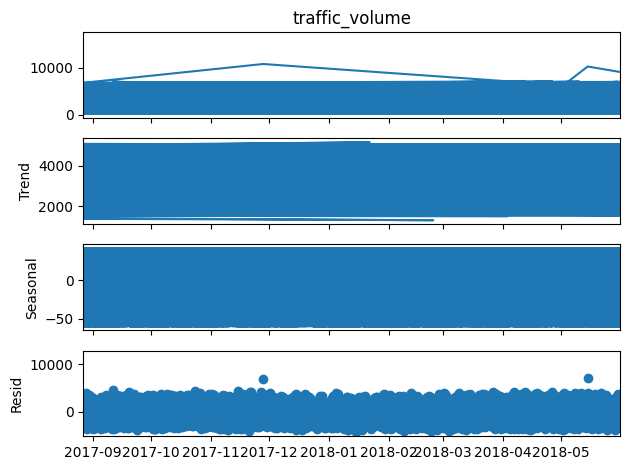

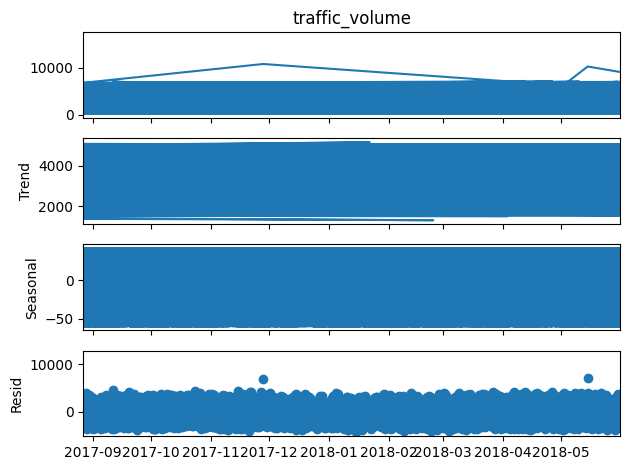

In [25]:
result = seasonal_decompose(df['traffic_volume'], model='additive', period=12)
result.plot()

<Axes: xlabel='date_time'>

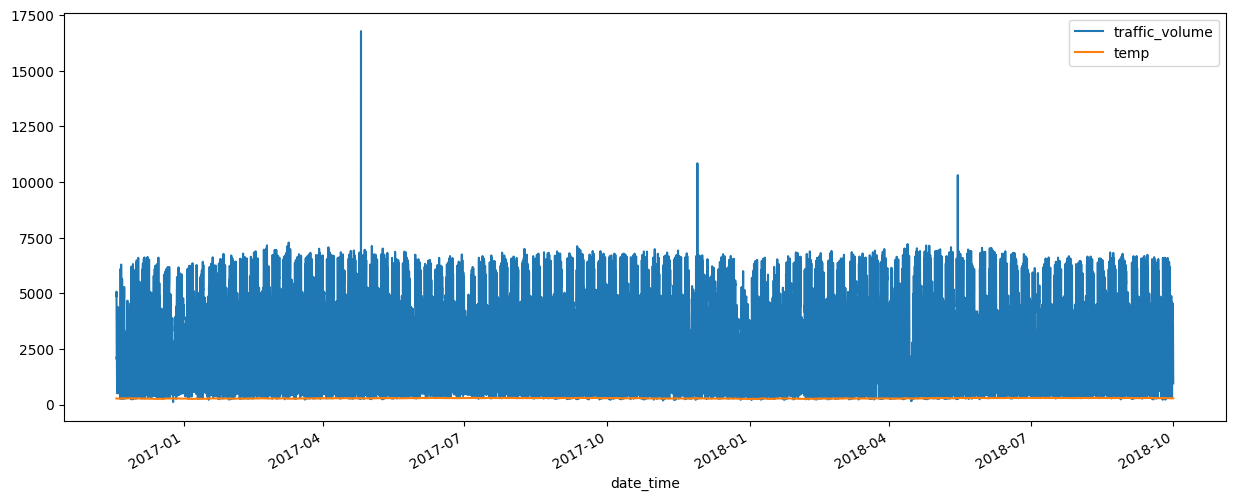

In [39]:
df.plot(figsize=(15, 6))

In [155]:
df.columns

Index(['traffic_volume', 'temp', 'weather_main'], dtype='object')

<Axes: xlabel='date_time'>

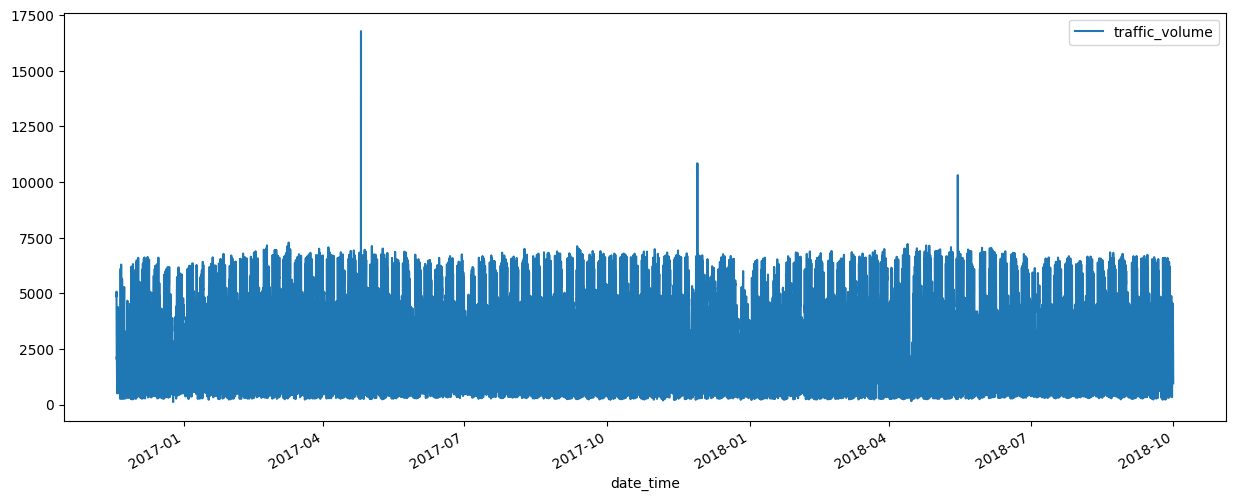

In [27]:
df[['traffic_volume']].plot(figsize=(15, 6))

<Axes: xlabel='date_time'>

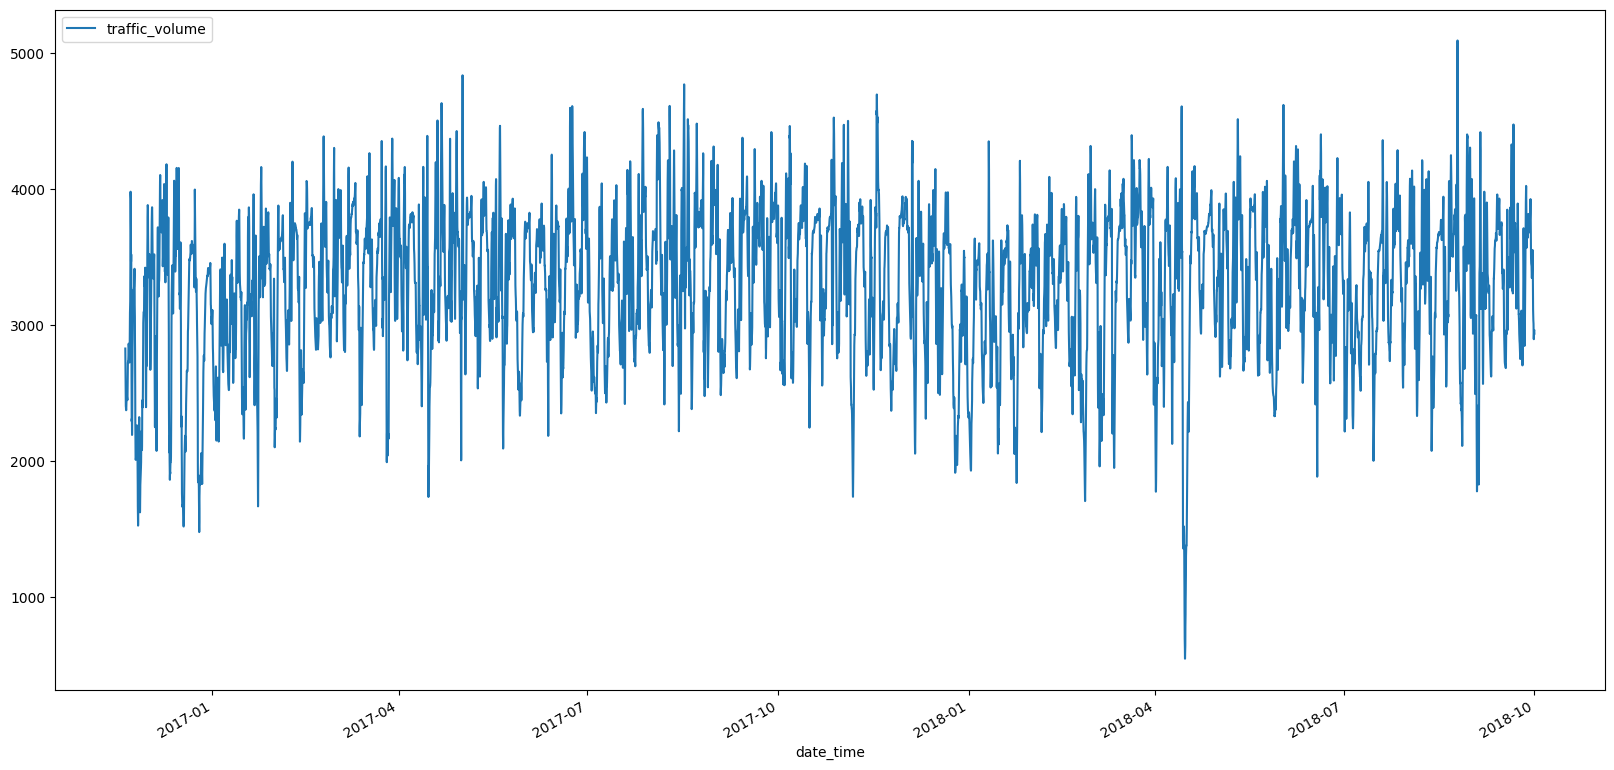

In [48]:
df[['traffic_volume']].rolling(48).mean().plot(figsize=(20,10))

<Axes: xlabel='date_time'>

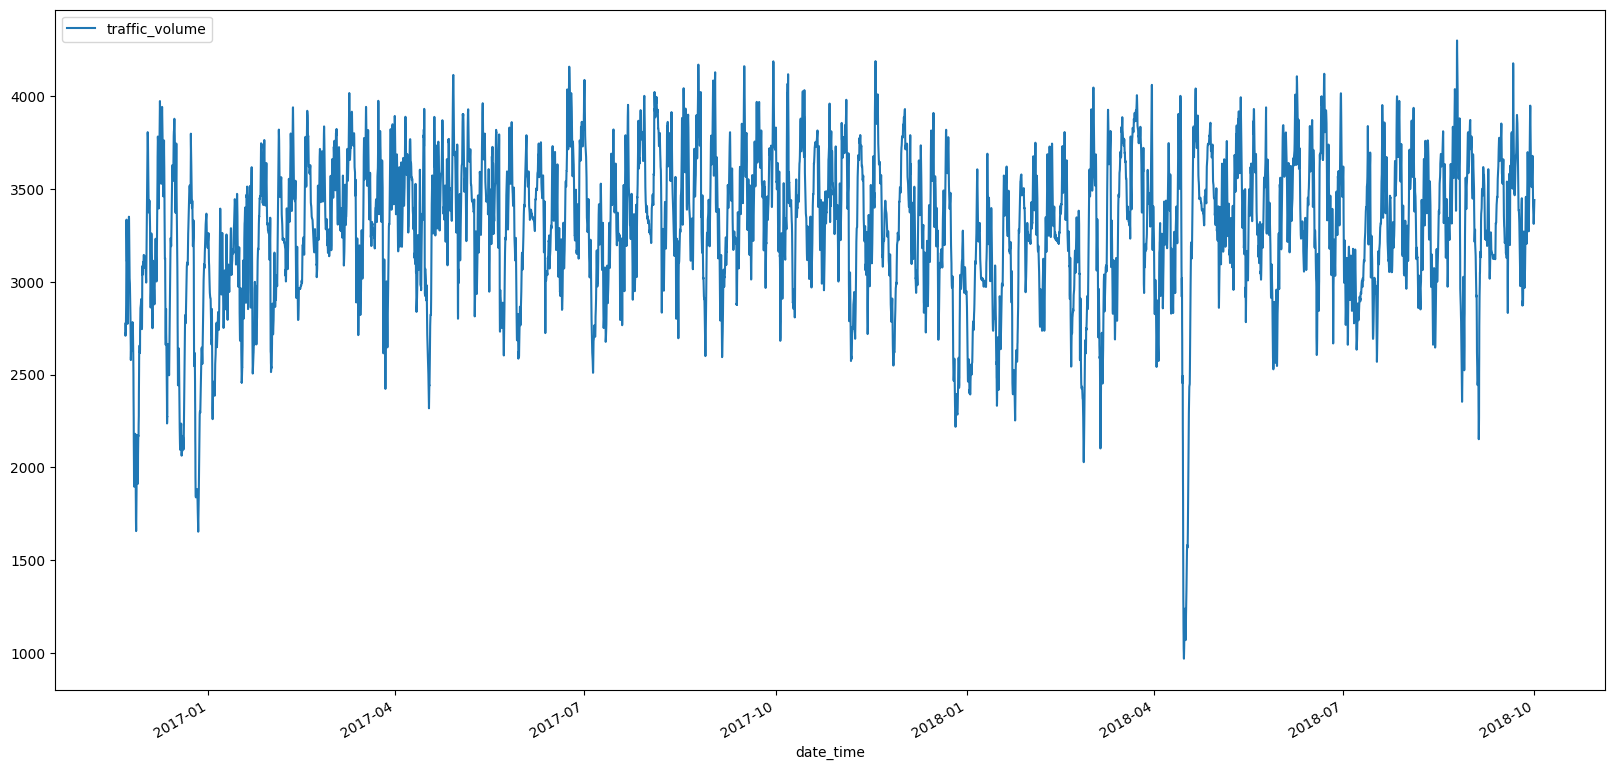

In [49]:
df[['traffic_volume']].rolling(96).mean().plot(figsize=(20,10))

<Axes: xlabel='date_time'>

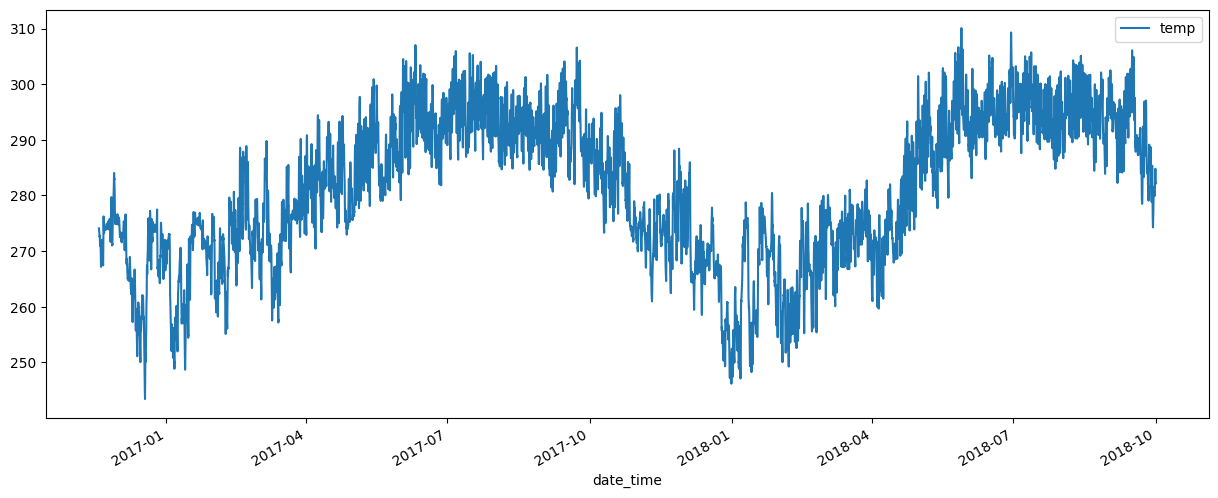

In [47]:
df[['temp']].plot(figsize=(15, 6))

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [225]:
df.describe()

,traffic_volume,temp
count,19980.000000,19980.000000
mean,3278.186887,281.158900
std,1977.171357,12.661612
min,113.000000,243.390000
25%,1228.750000,271.950000
50%,3430.000000,281.825000
75%,4928.000000,291.822500
max,16781.000000,310.070000


In [50]:
df.isna().sum()

,0
traffic_volume,0
temp,0
weather_main,0


In [226]:
df.sort_index(inplace=True)
df

,traffic_volume,temp,weather_main
date_time,,,
2016-11-18 15:00:00,4872.0,274.08,Snow
2016-11-18 15:00:00,4872.0,274.08,Mist
2016-11-18 15:00:00,4872.0,274.08,Fog
2016-11-18 16:00:00,5074.0,273.84,Snow
2016-11-18 16:00:00,5074.0,273.84,Mist
...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,Clouds
2018-09-30 20:00:00,2781.0,282.76,Clouds
2018-09-30 21:00:00,2159.0,282.73,Thunderstorm


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [227]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)

In [228]:
df.head()

,traffic_volume,temp,weather_main,prev_traffic_volume
date_time,,,,
2016-11-18 15:00:00,4872.0,274.08,Snow,NaN
2016-11-18 15:00:00,4872.0,274.08,Mist,4872.0
2016-11-18 15:00:00,4872.0,274.08,Fog,4872.0
2016-11-18 16:00:00,5074.0,273.84,Snow,4872.0
2016-11-18 16:00:00,5074.0,273.84,Mist,5074.0


In [229]:
df.fillna(4872.0, inplace=True)

In [230]:
df.head()

,traffic_volume,temp,weather_main,prev_traffic_volume
date_time,,,,
2016-11-18 15:00:00,4872.0,274.08,Snow,4872.0
2016-11-18 15:00:00,4872.0,274.08,Mist,4872.0
2016-11-18 15:00:00,4872.0,274.08,Fog,4872.0
2016-11-18 16:00:00,5074.0,273.84,Snow,4872.0
2016-11-18 16:00:00,5074.0,273.84,Mist,5074.0


In [231]:
df['difference_traffic_volume'] = df['traffic_volume'] - df['prev_traffic_volume']

In [232]:
df.head(10)

,traffic_volume,temp,weather_main,prev_traffic_volume,difference_traffic_volume
date_time,,,,,
2016-11-18 15:00:00,4872.0,274.08,Snow,4872.0,0.0
2016-11-18 15:00:00,4872.0,274.08,Mist,4872.0,0.0
2016-11-18 15:00:00,4872.0,274.08,Fog,4872.0,0.0
2016-11-18 16:00:00,5074.0,273.84,Snow,4872.0,202.0
2016-11-18 16:00:00,5074.0,273.84,Mist,5074.0,0.0
2016-11-18 16:00:00,5074.0,273.84,Fog,5074.0,0.0
2016-11-18 17:00:00,4328.0,273.62,Mist,5074.0,-746.0
2016-11-18 17:00:00,4328.0,273.62,Fog,4328.0,0.0
2016-11-18 17:00:00,4328.0,273.62,Snow,4328.0,0.0


In [233]:
df['Day_of_week'] = df.index.dayofweek

In [166]:
df.head()

,traffic_volume,temp,weather_main,prev_traffic_volume,difference_traffic_volume,Day_of_week
date_time,,,,,,
2016-11-18 15:00:00,4872.0,274.08,Snow,4872.0,0.0,4
2016-11-18 15:00:00,4872.0,274.08,Mist,4872.0,0.0,4
2016-11-18 15:00:00,4872.0,274.08,Fog,4872.0,0.0,4
2016-11-18 16:00:00,5074.0,273.84,Snow,4872.0,202.0,4
2016-11-18 16:00:00,5074.0,273.84,Mist,5074.0,0.0,4


In [234]:
df['Day_of_week'].unique()

array([4, 5, 6, 0, 1, 2, 3], dtype=int32)

In [235]:
df['Day_of_week'].replace([0, 1, 2, 3, 4, 5, 6], [ 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], inplace=True)

In [236]:
df.head()

,traffic_volume,temp,weather_main,prev_traffic_volume,difference_traffic_volume,Day_of_week
date_time,,,,,,
2016-11-18 15:00:00,4872.0,274.08,Snow,4872.0,0.0,Thursday
2016-11-18 15:00:00,4872.0,274.08,Mist,4872.0,0.0,Thursday
2016-11-18 15:00:00,4872.0,274.08,Fog,4872.0,0.0,Thursday
2016-11-18 16:00:00,5074.0,273.84,Snow,4872.0,202.0,Thursday
2016-11-18 16:00:00,5074.0,273.84,Mist,5074.0,0.0,Thursday


In [139]:
df['traffic_volume'].describe()

,traffic_volume
count,19980.000000
mean,3278.186887
std,1977.171357
min,113.000000
25%,1228.750000
50%,3430.000000
75%,4928.000000
max,16781.000000


In [237]:
def categorize_custom(row):
    if row['traffic_volume'] <= 1000:
        return 'low'
    elif row['traffic_volume'] <= 2500:
        return 'normal'
    elif row['traffic_volume'] <= 5000:
        return 'high'
    else:
        return 'heavy'

df['Category_of_Traffic'] = df.apply(categorize_custom, axis=1)

print(df)

                     traffic_volume    temp  weather_main  \
date_time                                                   
2016-11-18 15:00:00          4872.0  274.08          Snow   
2016-11-18 15:00:00          4872.0  274.08          Mist   
2016-11-18 15:00:00          4872.0  274.08           Fog   
2016-11-18 16:00:00          5074.0  273.84          Snow   
2016-11-18 16:00:00          5074.0  273.84          Mist   
...                             ...     ...           ...   
2018-09-30 19:00:00          3543.0  283.45        Clouds   
2018-09-30 20:00:00          2781.0  282.76        Clouds   
2018-09-30 21:00:00          2159.0  282.73  Thunderstorm   
2018-09-30 22:00:00          1450.0  282.09        Clouds   
2018-09-30 23:00:00           954.0  282.12        Clouds   

                     prev_traffic_volume  difference_traffic_volume  \
date_time                                                             
2016-11-18 15:00:00               4872.0                        

In [238]:
df.sample()

,traffic_volume,temp,weather_main,prev_traffic_volume,difference_traffic_volume,Day_of_week,Category_of_Traffic
date_time,,,,,,,
2017-01-12 04:00:00,843.0,257.34,Clouds,339.0,504.0,Wednesday,low


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [239]:
df.index

DatetimeIndex(['2016-11-18 15:00:00', '2016-11-18 15:00:00',
               '2016-11-18 15:00:00', '2016-11-18 16:00:00',
               '2016-11-18 16:00:00', '2016-11-18 16:00:00',
               '2016-11-18 17:00:00', '2016-11-18 17:00:00',
               '2016-11-18 17:00:00', '2016-11-18 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=19980, freq=None)

In [240]:
train = df.loc['2016-11-18 15:00:00':'2017-12-31 23:00:00']
val = df.loc['2018-01-01 00:00:00':'2018-04-30 23:00:00']
test = df.loc['2018-05-01 00:00:00':'2018-09-30 23:00:00']

In [241]:
train.shape, val.shape, test.shape

((12041, 7), (3453, 7), (4486, 7))

In [242]:
df.head()

,traffic_volume,temp,weather_main,prev_traffic_volume,difference_traffic_volume,Day_of_week,Category_of_Traffic
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,Snow,4872.0,0.0,Thursday,high
2016-11-18 15:00:00,4872.0,274.08,Mist,4872.0,0.0,Thursday,high
2016-11-18 15:00:00,4872.0,274.08,Fog,4872.0,0.0,Thursday,high
2016-11-18 16:00:00,5074.0,273.84,Snow,4872.0,202.0,Thursday,heavy
2016-11-18 16:00:00,5074.0,273.84,Mist,5074.0,0.0,Thursday,heavy


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [243]:
scaler = MinMaxScaler()
# lb = LabelEncoder()
ohe = OneHotEncoder()
oe = OrdinalEncoder()
# imputer = SimpleImputer(strategy='mean')
# pipe = make_pipeline(scaler)
num_pipe = make_pipeline(scaler)
cat_pipe = make_pipeline(oe)
preprocessing_pipe = make_column_transformer(
     (num_pipe, ['traffic_volume', 'temp', 'prev_traffic_volume', 'difference_traffic_volume']),
     (cat_pipe, ['weather_main','Day_of_week','Category_of_Traffic']))

preprocessing_pipe


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['traffic_volume', 'temp',
                                  'prev_traffic_volume',
                                  'difference_traffic_volume']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['weather_main', 'Day_of_week',
                                  'Category_of_Traffic'])])

In [244]:
train_pre = preprocessing_pipe.fit_transform(train)
val_pre = preprocessing_pipe.transform(val)
test_pre = preprocessing_pipe.transform(test)

In [245]:
train_pre.dtype, val_pre.dtype, test_pre.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

In [246]:
np.unique(train_pre[:,2])

array([0.        , 0.00437965, 0.00473962, ..., 0.4299856 , 0.6437485 ,
       1.        ])

In [247]:
df.head()

,traffic_volume,temp,weather_main,prev_traffic_volume,difference_traffic_volume,Day_of_week,Category_of_Traffic
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,Snow,4872.0,0.0,Thursday,high
2016-11-18 15:00:00,4872.0,274.08,Mist,4872.0,0.0,Thursday,high
2016-11-18 15:00:00,4872.0,274.08,Fog,4872.0,0.0,Thursday,high
2016-11-18 16:00:00,5074.0,273.84,Snow,4872.0,202.0,Thursday,heavy
2016-11-18 16:00:00,5074.0,273.84,Mist,5074.0,0.0,Thursday,heavy


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [249]:
from tensorflow.keras.utils import timeseries_dataset_from_array
window_size = 10
train_Xy = timeseries_dataset_from_array(train_pre, targets=train_pre[window_size:, 1], sequence_length=window_size)
val_Xy = timeseries_dataset_from_array(val_pre, targets=val_pre[window_size:, 1], sequence_length=window_size)
test_Xy = timeseries_dataset_from_array(test_pre, targets=test_pre[window_size:, 1], sequence_length=window_size)

In [271]:
X_train, y_train = next(iter(train_Xy))
X_train.shape, y_train.shape

(TensorShape([128, 10, 7]), TensorShape([128]))

In [272]:
X_val, y_val = next(iter(val_Xy))
X_val.shape, y_val.shape

(TensorShape([128, 10, 7]), TensorShape([128]))

In [273]:
X_test, y_test = next(iter(test_Xy))
X_test.shape, y_test.shape

(TensorShape([128, 10, 7]), TensorShape([128]))

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [251]:
from tensorflow import random
random.set_seed(42)

In [252]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential

model1 = Sequential([GRU(units=10, activation='tanh', return_sequences=True),
                    GRU(units=10, activation='tanh'),
                   Dense(units=1, activation='relu')])

model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model1.fit(train_Xy, validation_data=val_Xy, epochs=10, batch_size=100)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0354 - mae: 0.1498 - val_loss: 0.0188 - val_mae: 0.1085
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0149 - mae: 0.0984 - val_loss: 0.0163 - val_mae: 0.1018
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0138 - mae: 0.0954 - val_loss: 0.0147 - val_mae: 0.0969
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0134 - mae: 0.0951 - val_loss: 0.0140 - val_mae: 0.0930
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0135 - mae: 0.0963 - val_loss: 0.0150 - val_mae: 0.0940
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0140 - mae: 0.0983 - val_loss: 0.0190 - val_mae: 0.1064
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0150 - mae: 0.1008 - val_loss: 0.0231 - val_mae: 0.1200
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0163 - mae: 0.1039 - val_loss: 0.0206 - val_mae: 0.1150
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.016

In [262]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential

model1 = Sequential([GRU(units=20, activation='tanh', return_sequences=True),
                    GRU(units=10, activation='tanh', return_sequences=True),
                     GRU(units=10, activation='tanh', return_sequences=True),
                     GRU(units=10, activation='tanh', return_sequences=False),
                   Dense(units=1, activation='relu')])

model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model1.fit(train_Xy, validation_data=val_Xy, epochs=10)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.0549 - mae: 0.1750 - val_loss: 0.0185 - val_mae: 0.1145
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0152 - mae: 0.1002 - val_loss: 0.0193 - val_mae: 0.1178
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0150 - mae: 0.0998 - val_loss: 0.0191 - val_mae: 0.1177
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0147 - mae: 0.0989 - val_loss: 0.0184 - val_mae: 0.1155
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0141 - mae: 0.0974 - val_loss: 0.0175 - val_mae: 0.1127
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0135 - mae: 0.0962 - val_loss: 0.0168 - val_mae: 0.1100
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0131 - mae: 0.0953 - val_loss: 0.0161 - val_mae: 0.1074
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0128 - mae: 0.0948 - val_loss: 0.0155 - val_mae: 0.1049
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [199]:
X_val, y_val = next(iter(val_Xy))
X_val.shape, y_val.shape

(TensorShape([100, 10, 7]), TensorShape([100]))

In [203]:
y_pred_v = model1.predict(X_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [207]:
y_pred_v

array([[0.31957313],
       [0.31837833],
       [0.31683093],
       [0.32502377],
       [0.33520505],
       [0.34395388],
       [0.35096046],
       [0.35652065],
       [0.36069885],
       [0.3638497 ],
       [0.359963  ],
       [0.35265264],
       [0.34343192],
       [0.33645517],
       [0.3319598 ],
       [0.33321568],
       [0.3404608 ],
       [0.3320999 ],
       [0.32222864],
       [0.31671548],
       [0.3225004 ],
       [0.33221495],
       [0.36371967],
       [0.3665312 ],
       [0.36065495],
       [0.36011094],
       [0.3711693 ],
       [0.37552983],
       [0.38106483],
       [0.3860069 ],
       [0.4095587 ],
       [0.40003252],
       [0.3993499 ],
       [0.39891943],
       [0.40049374],
       [0.40164024],
       [0.4013347 ],
       [0.39968878],
       [0.39838952],
       [0.39240026],
       [0.3784402 ],
       [0.3833468 ],
       [0.3722905 ],
       [0.3626519 ],
       [0.3373632 ],
       [0.33795977],
       [0.32376054],
       [0.317

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [210]:
mae = mean_absolute_error(y_test, y_pred_v)
mse = mean_squared_error(y_test, y_pred_v)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.356095341991895
Mean Squared Error: 0.13258211005987552


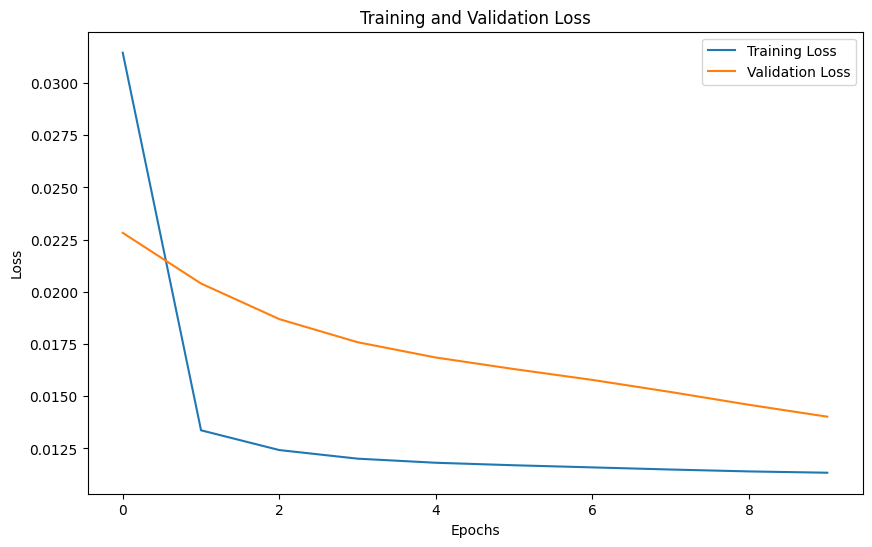

In [206]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [212]:
from tensorflow import random
random.set_seed(42)

In [261]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential

model2 = Sequential([LSTM(units=10, activation='tanh', return_sequences=True),
                    LSTM(units=10, activation='tanh', return_sequences=True),
                     LSTM(units=10, activation='tanh', return_sequences=False),
                   Dense(units=1, activation='relu')])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model2.fit(train_Xy, validation_data=val_Xy, epochs=10, batch_size=100)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0413 - mae: 0.1580 - val_loss: 0.0171 - val_mae: 0.1062
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0136 - mae: 0.0979 - val_loss: 0.0150 - val_mae: 0.0964
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0129 - mae: 0.0965 - val_loss: 0.0148 - val_mae: 0.0929
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0134 - mae: 0.0980 - val_loss: 0.0159 - val_mae: 0.0933
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0150 - mae: 0.1022 - val_loss: 0.0207 - val_mae: 0.1073
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0181 - mae: 0.1086 - val_loss: 0.0335 - val_mae: 0.1498
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0227 - mae: 0.1202 - val_loss: 0.0518 - val_mae: 0.1988
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0278 - mae: 0.1362 - val_loss: 0.0521 - val_mae: 0.1995
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.02

In [270]:
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential

model2 = Sequential([LSTM(units=10, activation='tanh', return_sequences=True),
                   Dense(units=1, activation='relu')])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_Xy, epochs=10, validation_data=(val_Xy),callbacks=[early_stopping])

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3.2164e-04 - mae: 0.0130 - val_loss: 4.5309e-04 - val_mae: 0.0155
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.0948e-04 - mae: 0.0127 - val_loss: 4.2865e-04 - val_mae: 0.0153
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 2.9975e-04 - mae: 0.0125 - val_loss: 4.1226e-04 - val_mae: 0.0154
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 2.9300e-04 - mae: 0.0124 - val_loss: 4.0423e-04 - val_mae: 0.0155
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.8903e-04 - mae: 0.0124 - val_loss: 4.0117e-04 - val_mae: 0.0157
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.8709e-04 - mae: 0.0125 - val_loss: 3.9945e-04 - val_mae: 0.0159
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 2.8662e-04 - mae: 0.0126 - val_loss: 3.9698e-04 - val_mae: 0.0159
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 2.8718e-04 - mae: 0.0127 - val_loss: 3.9238e-04 - val_mae: 0.0159


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [263]:
X_val, y_val = next(iter(val_Xy))
X_val.shape, y_val.shape

(TensorShape([128, 10, 7]), TensorShape([128]))

In [264]:
y_pred_v = model2.predict(X_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  


In [265]:
y_pred_v

array([[0.57526755],
       [0.5751977 ],
       [0.57447517],
       [0.5746484 ],
       [0.57603437],
       [0.5791079 ],
       [0.5838149 ],
       [0.5897916 ],
       [0.5969091 ],
       [0.6047014 ],
       [0.61133873],
       [0.6155137 ],
       [0.61606467],
       [0.6113851 ],
       [0.6059881 ],
       [0.6017088 ],
       [0.5969278 ],
       [0.59507275],
       [0.5964145 ],
       [0.60021293],
       [0.6051819 ],
       [0.6094665 ],
       [0.6144386 ],
       [0.6182639 ],
       [0.6217452 ],
       [0.6251153 ],
       [0.6211542 ],
       [0.62376356],
       [0.62617356],
       [0.6278144 ],
       [0.63171613],
       [0.6323632 ],
       [0.6354717 ],
       [0.6355951 ],
       [0.6373594 ],
       [0.6369668 ],
       [0.6356334 ],
       [0.6330845 ],
       [0.6306637 ],
       [0.62825155],
       [0.63032573],
       [0.630999  ],
       [0.62889594],
       [0.6304402 ],
       [0.6287405 ],
       [0.63062   ],
       [0.62869096],
       [0.629

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [266]:
mae = mean_absolute_error(y_test, y_pred_v)
mse = mean_squared_error(y_test, y_pred_v)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 0.11397944423701599
Mean Squared Error: 0.017472091217324633


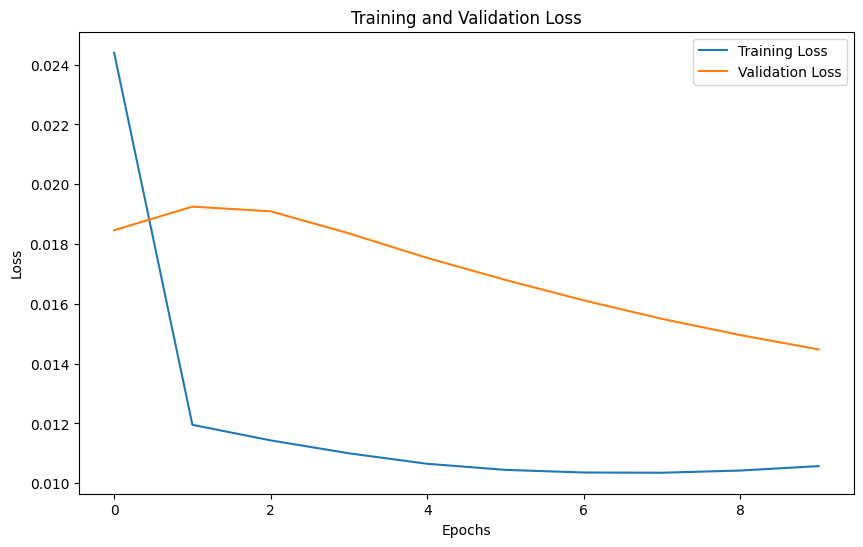

In [267]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:



*   After spliting the data into train, test and validate I scalled the categorical values into numerical ones and scalled the numerical, and that because I dont want it to shuffle randomly, I also split the data in that way for the same reason .
*   I set number one in the shift(1) because we want to the previous values and not the next , then I display the current values to fill the previous nan.
*   I add a new column for the day of the week using df.index.dayofweek to enhance my model by adding more features
*   I added new column named (category of traffic volume) with 4 classes(low, normal, high, heavy) just to understand the traffic volume

*  By choosing GRU from my point of view I think its faster than the SimpleRNN and LSTM
*   also by choosing LSTM rather than SimpleRNN for the same reason and LSTM its performe better for complex dataset than the SimpleRNN
*  By minmizing the number of untis in GRU its seem it preform better than adding more units and layers .


*   For LSTM adding more layers and units it peforme so good that reaching to an overfitting
*   an overfitting in the second model using LSTM


*   Mean Absolute Error: 0.3560, Mean Squared Error: 0.1325 for the first model GRU
*   Mean Absolute Error: 0.11397 , Mean Squared Error: 0.01747 for the second model LSTM which is an overfitting


*   In this case I would use (early stopping) to handle the overfitting in the second model. but still there is an overfitting











